# Cell Segmentation for MERFISH

This tutorial demonstrates how to use MERFISH Tools to replace the MERlin/MERSCOPE segmentation with a different segmentation to produce a new cell by gene table.

NOTE: This first section shows how to use MERFISH Tools to produce segmentation masks using cellpose. Currently, MERFISH Tools does not allow much customization of the cellpose parameters, so you may want to produce your own masks using cellpose outside of MERFISH Tools or using a different segmentation method. If you already have produced segmentation masks, you can skip this first section

## Segmenting with cellpose

In [1]:
import sys
sys.path.append("/home/jckern/merfish_pipeline_dev")

The first step is to create an `ImageDataset` instance which is a class for loading raw images from disk. The optional `segdict` parameter will specify which images should be used for segmentation. The `channel` refers to the `dataorganization.csv` file in the MERSCOPE's raw data folders that defines how the images are organized. `DAPI` or `PolyT` are recommended. The `zslice` refers to which 2D frame to use for segmentation. Currently, MERFISH Tools integration of cellpose does not support 3D segmentation or segmentation using both the DAPI and PolyT staining.

In [10]:
from mftools.fileio import ImageDataset

imageset = ImageDataset("/mnt/merfish4v1/RNA_MERFISH/MERSCOPE/Data/202212021545_20221202M064BA19S09352_VMSC02201", segdict={"channel": "DAPI", "zslice": 3})

Next we can create a `CellSegmentation` instance and provide it the `ImageDataset` we created above.

In [3]:
from mftools.segmentation import CellSegmentation

seg = CellSegmentation(imagedata=imageset)

Now `seg` can be indexed to access the mask for that FOV. In this case, because we did not create a `CellSegmentation` instance by providing a folder path containing pre-existing masks, cellpose will be used to create the mask the first time it is accessed.

In [5]:
mask = seg[100]

We can check the quality of the segmentation by plotting in over the DAPI or PolyT staining images. We can use `imageset` to load the image.

In [6]:
dapi = imageset.load_image(channel="DAPI", fov=100, max_projection=True)

Then `matplotlib` can be used to show the staining image and draw the segmented cell boundaries.

(-0.5, 2047.5, 2047.5, -0.5)

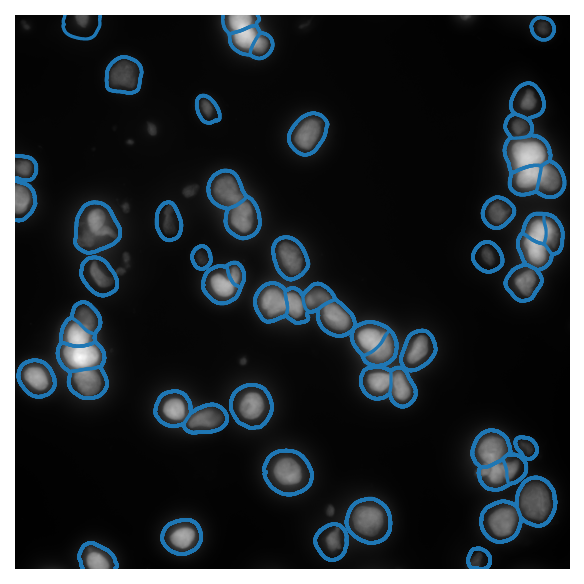

In [10]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(dpi=150)
plt.imshow(dapi, cmap="gray")
plt.contour(mask, [x+0.5 for x in np.unique(mask)], colors="tab:blue")
plt.axis("off");

The cell boundaries can cover the visible borders between cells in the staining image, making it hard to evaluate if certain areas are properly segmented. We can alternatively find the centroids of each cell and plot dots at the centroids instead of drawing the cell boundaries.

In [16]:
from skimage.measure import regionprops

centroids = np.array([cell.centroid for cell in regionprops(mask)])

(-0.5, 2047.5, 2047.5, -0.5)

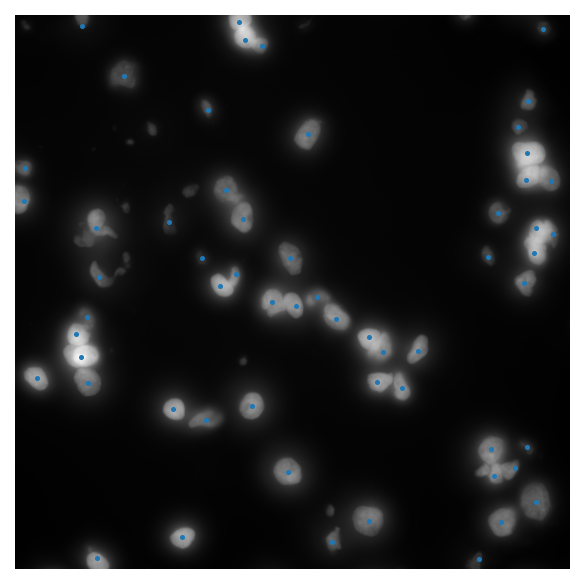

In [20]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(dpi=150)
plt.imshow(dapi, cmap="gray")
plt.scatter(centroids[:,1], centroids[:,0], c="tab:blue", s=2)
plt.axis("off");

The above can be repeated with different z-slices and staining types to find what is optimal for segmentation. Once the desired settings are found, the `CellSegmentation` instance can be re-created, this time giving a path to a mask folder. When masks are accessed from this object, it will first check if a mask file exists in the folder and load it, otherwise the mask will be created and then saved to the folder. 

In [11]:
seg = CellSegmentation("/mnt/merfish4v1/RNA_MERFISH/MERSCOPE/Output/202212021545_20221202M064BA19S09352_VMSC02201_cellpose/masks", imagedata=imageset)

## Generating a new cell by gene table

To create a cell by gene table from a custom cell segmentation, first create a `CellSegmentation` instance with the path to the folder containing the segmentation masks.

<div class="alert alert-info">

**Note**
    
If you are using MERFISH Tools to create a new cell segmentation with cellpose (see section above), skip this step and use the `CellSegmentation` created above with the image dataset.

</div> 

In [2]:
from mftools.segmentation import CellSegmentation

seg = CellSegmentation("/mnt/merfish4v1/RNA_MERFISH/MERSCOPE/Output/202212021545_20221202M064BA19S09352_VMSC02201_cellpose/masks")

/home/jckern/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We can now create the cell metadata table from the segmentation masks, which contains the local and global coordinates of each cell and the volume of the cell. Many of the 

In [6]:
metadata = seg.metadata

Getting cell volumes and centers: 1934it [27:25,  1.18it/s]


Segmented cells: 121278


Combining cell volumes in overlaps: 100%|██████████| 17154/17154 [00:42<00:00, 407.28it/s]

Median cell volume (pixels): 12618.0


,fov_y,fov_x,fov,global_x,global_y,volume
cell_id,,,,,,
10063,1857.890837,972.220887,1,-5295.562209,-1600.421883,5075.0
50001,23.652784,84.729059,5,-5190.898246,-797.459174,7560.0
50002,76.358058,186.309662,5,-5179.986267,-791.797474,6148.5
50035,477.522759,28.776028,5,-5196.908825,-748.70361,6349.0
50036,469.05938,80.486804,5,-5191.353957,-749.612762,3486.0
...,...,...,...,...,...,...
19320128,1853.684543,1213.015168,1932,5730.304364,1999.126269,11076.0
19320138,1876.111609,1049.904061,1932,5712.782663,2001.535427,8414.5
19320142,1940.366756,814.383512,1932,5687.482604,2008.437835,7460.0


To save the cell metadata table, we can create a `MerfishAnalysis` object with a path for the output folder.

<div class="alert alert-info">

**Note**
    
This should be different from the output folder that contains the cell metadata table created by the MERSCOPE so that it isn't overwritten.

</div> 

In [2]:
from mftools.fileio import MerfishAnalysis

output = MerfishAnalysis("/mnt/merfish4v1/RNA_MERFISH/MERSCOPE/Output/202212021545_20221202M064BA19S09352_VMSC02201_cellpose")

/home/jckern/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
output.save_cell_metadata(metadata)

Now we need to load the detected transcripts from the MERSCOPE output so that they can be assigned to cells in the new cell segmentation.

In [4]:
original = MerfishAnalysis("/mnt/merfish4v1/RNA_MERFISH/MERSCOPE/Output/202212021545_20221202M064BA19S09352_VMSC02201")

In [5]:
barcodes = original.load_barcode_table()

In [6]:
from mftools.barcodes import assign_to_cells
assign_to_cells(barcodes, seg)

Assigning barcodes to cells: 100%|██████████| 1923/1923 [05:26<00:00,  5.88it/s]


Barcodes assigned to cells: 18510281
% barcodes assigned to cells: 0.493451773112453


We can plot the detected transcripts and show those assigned to cells in a different color as those outside of cells. If it doesn't look right, there may be a mismatch in the coordinate systems of the segmentation masks and detected transcripts. The `transpose`, `flip_x`, and `flip_y` parameters of `assign_to_cells` may help to fix such a mismatch. The defaults to these parameters should work for experiments done on a MERSCOPE and segmentation masks generated by cellpose.

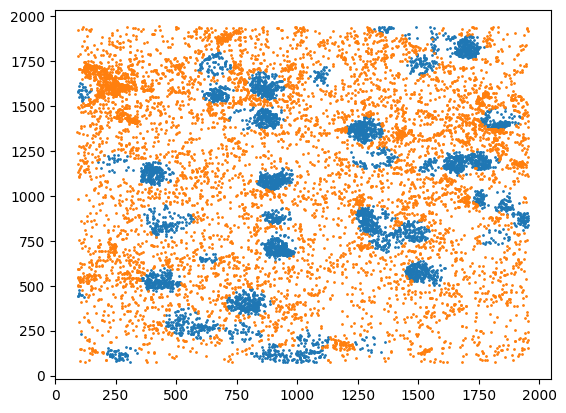

In [8]:
import matplotlib.pyplot as plt
incells = barcodes[(barcodes['fov'] == 150) & (barcodes['cell_id'] != 0)]
plt.scatter(incells['x'], incells['y'], s=1)
outcells = barcodes[(barcodes['fov'] == 150) & (barcodes['cell_id'] == 0)]
plt.scatter(outcells['x'], outcells['y'], s=1)

In [12]:
from mftools.barcodes import link_cell_ids

link_cell_ids(barcodes, seg.linked_cells)

Linking cells in overlaps: 100%|██████████| 3759/3759 [04:16<00:00, 14.63it/s]


Cells with barcodes: 98182


KeyError: 'Segmented cells'

In [7]:
output.save_barcode_table(barcodes)

In [3]:
barcodes = output.load_barcode_table()

In [6]:
from mftools.barcodes import create_cell_by_gene_table
cbgtab = create_cell_by_gene_table(barcodes)

In [7]:
cbgtab.index = cbgtab.index.astype(int)

In [9]:
output.save_cell_by_gene_table(cbgtab)